In [3]:
# import intake
import xarray as xr
import numpy as np
import matplotlib.pylab as plt
import matplotlib.cm as cm
import cmocean.cm as cmo
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.interpolate import CloughTocher2DInterpolator, LinearNDInterpolator, NearestNDInterpolator
import gribscan
import intake

# Pressure level output from IFS

### Load pressure level data with open_zarr(), time, lon, lat

In [2]:
# Old way, do not use
# # json file was already prepared with gribscan-index and gribscan-build command line tools
# resolution='tco2559-ng5'
# gribfiles='ICMUAall' 
# datapath='/work/bm1235/a270046/cycle2-sync/'+resolution+'/'+gribfiles
# datazarr=datapath+'/json.dir/atm3d.json' # all 3D pressure level fields, this is the whole dataset!
# data = xr.open_zarr("reference::"+datazarr, consolidated=False)

In [7]:
cat = intake.open_catalog("../catalog.yaml")
run = cat.IFS["tco2559-ng5"]
data = run.ICMU_atm3d.to_dask()

Get the grid

In [8]:
model_lon = data.lon.values
model_lat = data.lat.values
# nonan = ~((np.isnan(model_lon)) | (np.isnan(model_lat)))
# lat_nonan = model_lat[nonan]
# lon_nonan = model_lon[nonan]
model_lon = np.where(model_lon>180, model_lon-360, model_lon)

List the variables included

In [9]:
data

<xarray.Dataset>
Dimensions:  (time: 1389, level: 23, value: 26306560)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 10 30 50 70 100 150 ... 875 900 925 950 975 1000
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/15)
    cc       (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    ciwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    clwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    crwc     (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    cswc     (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    d        (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    ...       ...
    u        (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    v        (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    vo       (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    w        (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    z        (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
    ~        (time, level, value) float64 dask.array<chunksize=(1, 1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

In [10]:
# more information on a variable, whole list is in the cell above under "Data variables"
data.variables['t']

,Array,Chunk
Bytes,6.11 TiB,200.70 MiB
Shape,"(1389, 23, 26306560)","(1, 1, 26306560)"
Count,31948 Tasks,31947 Chunks
Type,float64,numpy.ndarray


In [11]:
data.level

<xarray.DataArray 'level' (level: 23)>
array([   1,   10,   30,   50,   70,  100,  150,  200,  250,  300,  400,  500,
        600,  700,  750,  800,  850,  875,  900,  925,  950,  975, 1000])
Coordinates:
  * level    (level) int64 1 10 30 50 70 100 150 ... 875 900 925 950 975 1000

In [12]:
# select a date, level, and convert to deg C
data_sample = data.t.sel(time='2020-02-02-00:00:00',level=850.) - 273.15

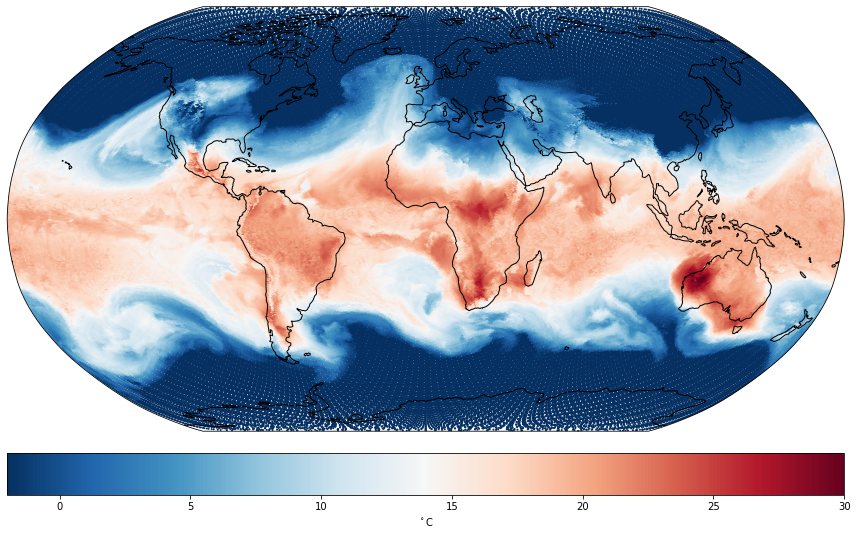

In [13]:
# sstep controls the spacing between points to plot
sstep=64

# plot using the simple scatter method:
plt.figure(figsize=(15,10))
# plot using Robinson projection.
#ax = plt.axes(projection=ccrs.PlateCarree())
ax = plt.axes(projection=ccrs.Robinson())
ax.coastlines(resolution='110m', color='k')

sc=ax.scatter(model_lon[::sstep], model_lat[::sstep], s=1 , c=data_sample[::sstep],cmap=cm.RdBu_r, transform=ccrs.PlateCarree(), vmin=-2.,vmax=30.)
# Add colorbar
cbar=plt.colorbar(sc,orientation='horizontal', pad=0.04)
cbar.set_label('$^\circ$C')
#plt.clim(-20, 29.) 

Interpolate to...

In [15]:
lon = np.linspace(-30, 60, 90*10)
lat = np.linspace(33, 72, (72-33)*10)
lon2, lat2 = np.meshgrid(lon, lat)

points_ifs = np.vstack((model_lon, model_lat)).T

nn_interpolation = NearestNDInterpolator(points_ifs, data_sample.values)
interpolated_nn = nn_interpolation((lon2, lat2))

Plot

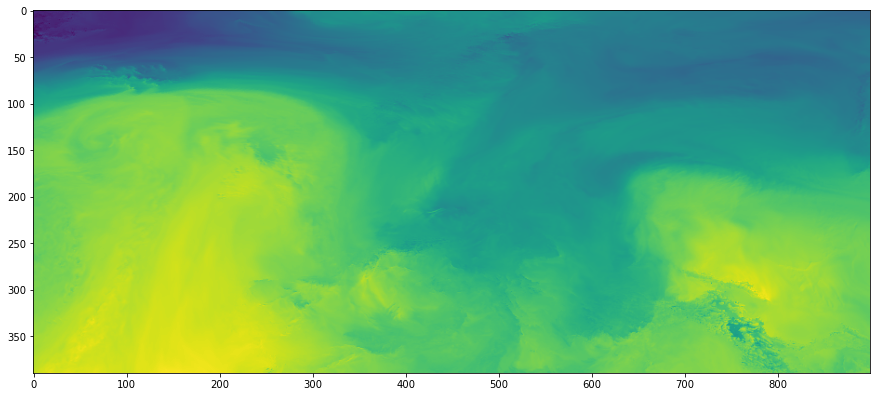

In [16]:
plt.figure(figsize=(15,15))
plt.imshow(np.flipud(interpolated_nn))

## Find point on the map

In [17]:
def tunnel_fast1d(latvar, lonvar, lonlat):
    """
    Find closest point in a set of (lat,lon) points to specified pointd.
    Parameters:
    -----------
        latvar : ndarray
            1d array with lats
        lonvar : ndarray
            1d array with lons
        lonlat : ndarray
            2d array with the shape of [2, number_of_point],
            that contain coordinates of the points
    Returns:
    --------
        node : int
            node number of the closest point
    Taken from here http://www.unidata.ucar.edu/blogs/developer/en/entry/accessing_netcdf_data_by_coordinates
    and modifyed for 1d
    """

    rad_factor = np.pi / 180.0  # for trignometry, need angles in radians
    # Read latitude and longitude from file into numpy arrays
    latvals = latvar[:] * rad_factor
    lonvals = lonvar[:] * rad_factor

    # Compute numpy arrays for all values, no loops
    clat, clon = np.cos(latvals), np.cos(lonvals)
    slat, slon = np.sin(latvals), np.sin(lonvals)

    clat_clon = clat * clon
    clat_slon = clat * slon

    lat0_rad = lonlat[1, :] * rad_factor
    lon0_rad = lonlat[0, :] * rad_factor

    delX_pre = np.cos(lat0_rad) * np.cos(lon0_rad)
    delY_pre = np.cos(lat0_rad) * np.sin(lon0_rad)
    delZ_pre = np.sin(lat0_rad)

    nodes = np.zeros((lonlat.shape[1]))
    for i in range(lonlat.shape[1]):
        delX = delX_pre[i] - clat_clon
        delY = delY_pre[i] - clat_slon
        delZ = delZ_pre[i] - slat
        dist_sq = delX ** 2 + delY ** 2 + delZ ** 2
        minindex_1d = dist_sq.argmin()  # 1D index of minimum element
        node = np.unravel_index(minindex_1d, latvals.shape)
        nodes[i] = node[0]

    return nodes.astype('int')

In [18]:
lon_target = -10
lat_target = 50

In [19]:
points = np.array([[lat_target],[lon_target]])

In [20]:
index = tunnel_fast1d(model_lon, model_lat, points)

In [22]:
model_lon[index[0]]

-10.019723865877722

In [23]:
model_lat[index[0]]

49.9921875

In [24]:
data['t']

<xarray.DataArray 't' (time: 1389, level: 23, value: 26306560)>
dask.array<open_dataset-b09e1e18268e4fa839f83737b7709191t, shape=(1389, 23, 26306560), dtype=float64, chunksize=(1, 1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 10 30 50 70 100 150 ... 875 900 925 950 975 1000
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes:
    paramId:                    130
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                isobaricInhPa
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  t
    units:                      K
    name:                       Temperature
    cfName:                     air_temperature
    cfVarName:                  t
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

In [25]:
lev=22
data['t'][:, lev, index[0]]

<xarray.DataArray 't' (time: 1389)>
dask.array<getitem, shape=(1389,), dtype=float64, chunksize=(1,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 dask.array<chunksize=(), meta=np.ndarray>
    level    int64 1000
    lon      float64 dask.array<chunksize=(), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T06:00:00 ... 2021-01-01
Attributes:
    paramId:                    130
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                isobaricInhPa
    stepUnits:                  1
    stepType:                   instant
    gridType:                   reduced_gg
    shortName:                  t
    units:                      K
    name:                       Temperature
    cfName:                     air_temperature
    cfVarName:                  t
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

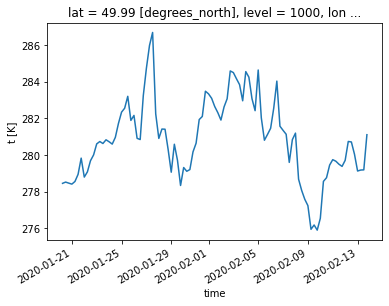

In [26]:
data['t'][1:100, lev, index[0]].plot()

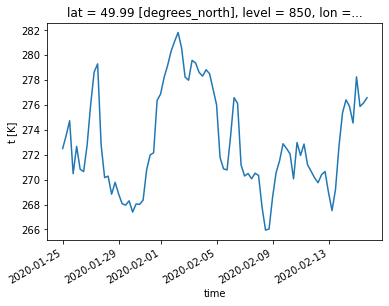

In [27]:
data['t'].sel(time=slice('2020-01-25','2020-02-15'), level=850.)[:,index[0]].plot()